In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from scipy import stats

In [6]:
# Download necessary NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Open Multilingual WordNet

True

### All combined data are : 18156 -> Dropping NAN values -> 17630 

In [8]:
# Load data
all_data = pd.read_csv('all_data.csv')
all_data

,commit_hash,commit_msg,author_name,author_email,committer_date,num_changed_files,file_path,complexity,nloc,readability_before,readability_after,readability_delta,repository,readability_improved
0,e27759bff79eef57f57e709f958fe22d45ced1a1,Fix error reporting verbage.,Christian Edward Gruber,christianedwardgruber@gmail.com,2011-05-25T10:34:31-04:00,1,src/main/java/org/junit/contrib/truth/Subject....,6,26,0.789958,0.792084,0.002126,google-truth-data,True
1,1bff3e1120e30d7e3f712a79146e8a11de70fbfe,copyrights.,Christian Edward Gruber,christianedwardgruber@gmail.com,2011-06-01T17:10:39-04:00,13,src/main/java/org/junit/contrib/truth/Expect.java,7,41,0.784772,0.784772,0.000000,google-truth-data,False
2,1bff3e1120e30d7e3f712a79146e8a11de70fbfe,copyrights.,Christian Edward Gruber,christianedwardgruber@gmail.com,2011-06-01T17:10:39-04:00,13,src/main/java/org/junit/contrib/truth/FailureS...,0,4,0.817928,0.817928,0.000000,google-truth-data,False
3,1bff3e1120e30d7e3f712a79146e8a11de70fbfe,copyrights.,Christian Edward Gruber,christianedwardgruber@gmail.com,2011-06-01T17:10:39-04:00,13,src/main/java/org/junit/contrib/truth/IntSubje...,1,6,0.738782,0.738782,0.000000,google-truth-data,False
4,1bff3e1120e30d7e3f712a79146e8a11de70fbfe,copyrights.,Christian Edward Gruber,christianedwardgruber@gmail.com,2011-06-01T17:10:39-04:00,13,src/main/java/org/junit/contrib/truth/StringSu...,3,12,0.749124,0.749124,0.000000,google-truth-data,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17625,73768be112357ec7358c15de8b7f72285732571e,Replace anonymous classes with lambdas in test...,Andrey Litvitski,120543954+panic08@users.noreply.github.com,2024-10-18T07:32:50-07:00,14,gson/src/test/java/com/google/gson/functional/...,5,128,0.815528,0.823274,0.007746,google-gson-data,True
17626,2dc29f7a15f6c2b6de384e8e1e545f20b1c8d5df,Replace anonymous class creation with lambdas ...,Andrey Litvitski,120543954+panic08@users.noreply.github.com,2024-10-18T07:33:47-07:00,1,gson/src/main/java/com/google/gson/internal/Co...,29,270,0.803177,0.649248,-0.153930,google-gson-data,False
17627,e430a3d181e63d1efac05164bf52ec0466af12b7,Use better names for lambda parameters in test...,Marcono1234,Marcono1234@users.noreply.github.com,2024-10-20T09:41:34-07:00,1,gson/src/test/java/com/google/gson/functional/...,24,440,0.544673,0.546713,0.002040,google-gson-data,True
17628,3e5ccb171a56b3278f7123638631b945ec52e5cb,Change the use of == operator to isEmpty() in ...,Andrey Litvitski,120543954+panic08@users.noreply.github.com,2024-10-20T09:48:09-07:00,1,gson/src/main/java/com/google/gson/JsonObject....,28,75,0.893521,0.893698,0.000177,google-gson-data,True


In [10]:
# Basic data exploration
print(f"Total records: {len(all_data)}")
print(f"Records per repository:")
print(all_data['repository'].value_counts())

Total records: 17630
Records per repository:
repository
google-guice-data    8248
google-truth-data    4801
google-gson-data     4581
Name: count, dtype: int64


In [12]:
# Check the distribution of readability improvement
improved_count = all_data['readability_improved'].sum()
decreased_count = len(all_data) - improved_count
print(f"Commits with improved readability: {improved_count} ({improved_count/len(all_data)*100:.1f}%)")
print(f"Commits with decreased readability: {decreased_count} ({decreased_count/len(all_data)*100:.1f}%)")


Commits with improved readability: 7088 (40.2%)
Commits with decreased readability: 10542 (59.8%)


### Preprocess func

In [15]:
# Text preprocessing function for commit messages
def preprocess_text(text, frequent_words=None, max_freq_words=50, correct_spelling=False):
    # Handle potential NaN or non-string values
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase and remove special characters
    text = str(text).lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs - this should come before other character removal
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', ' ', text)      # Remove numbers
    # Remove extra whitespace (including multiple spaces, tabs, and newlines)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()  # Remove leading and trailing whitespace
    
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    
    # Add domain-specific stopwords
    domain_stopwords = {
        'ticket', 'commit', 'set', 'impl', 'file', 'files','char','current', 'highlight', 'miss','direct', 'initi',
        'rather', 'migrat', ' formatt','version', 'branch', 'git','https', 'http', 'issu','common', 'codec',''
        'jakarta','junit', 'filesystem', 'proper', 'moe_migrated_revid', 'testcase', 'package', 'import', 'java', 'method',
        'user', 'github', 'objects', 'field', 'static', 'private', 'public', 'exception', 'guava', 'type', 'string', 'array',
        'assert', 'warning', 'modul', 'googl','gener','sinc','googlecod', 'argument', 'parameter', 'unused', 'override', 'moe',
        'guice', 'message', 'aecad', 'dependency', 'support', 'final', 'provider', 'filepath', 'filename', 'constant', 
        'piperorigin', 'googlecode', 'truth', 'include', 'relnotes', 'instance', 'instances', 'types', 'interface', 'interfaces',
        'jar','maven', 'gradle', 'junit','test', 'tests', 'protected', 'static', 'final', 'abstract', 'interface', 'extends', 'void',
        'boolean', 'int', 'string', 'list', 'make', 'move', 'call', 'base', 'camel', 'minor', 'local', 'line', 'instead',
        'member', 'author', 'pom', 'cherry', 'picked', 'grgit', 'license', 'value', 'javax', 'key', 'number', 'one', 'aop',
        'object', 'work', 'actual', 'values', 'source', 'testing', 'using', 'subject', 'time', 'internal', 'still', 'parameters',
        'element', 'step', 'tool', 'jspecify', 'factory', 'module', 'newinstance', 'new', 'added', 'initial', 'scope', 
        'moe_migration', 'instaceof', 'presubmit', 'adding', 'ensure', 'notice', 'formatter', 'push_codebase', 'main',
        'thing', 'strut', 'until', 'rest', 'extension', 'also', 'like', 'nullmarked', 'even', 'since', 'com', 'author', 'svn',
        'assert', 'error', 'deprec', 'foo', 'call', 'mothod','messag', 'chang', 'updat','thi','guic','src','marcono', 
        'gson','contain', 'gener', "trunk", 'user','master', 'pull', 'push', 'rebase', 'checkout', 'tag', 'head' , 'rev', 'revision',
        'repository', 'repo', 'feature', 'jira', 'tracker', 'cel', 'guava', 'aecad', 'modul', 'csv', 'properties', 'java', 'xml', 
        'json', 'txt', 'piperorigin', 'org', 'io', 'gitlab', 'bitbucket', 'pom', 'mvn','gradle', 'compile', 'runtime', 'scope',
        'artifact', 'group', 'sdk', 'lib', 'library', 'framework', 'plugin', 'extension', 'tool', 'utility', 'util', 'helper', 'service', 'provider', 
        'factory', 'builder', 'manager', 'handler', 'controller', 'view', 'minor', 'major', 'small', 'pr', 'updates', 'fixes', 'fixed', 
        'fixing',  'updated', 'updating','big', 'temporary', 'temp', 'misc', 'various', 'several', 'multiple', 'few', 'many', 'intital', 'first',
        'final', 'last', 'todo', 'fixme','wip', 'work', 'progress', 'draft', 'experimental','camel', 'cherry', 'picked', 'aop', 'persubmit', 'ensure',
        'formatter', 'thing', 'function', 'variable', 'variabls', 'arguments', 'relnot','messag','avoid', 'includ', 'valu','depend', 'contain',
        'check','bind','use', 'path','instanc','onli','define', 'given', 'norepli', 'deprec', 'paramet', 'return', 'equal', 'ensure', 'port', 'factori',
        'need', 'failure', 'run', 'build', 'unus', 'sourc','nullabl', 'null', 'follow','jspecifi', 'ani', 'strict', 'behavior', 'expos',
        'modifi', 'instanceof','introduc', 'defin', 'complic', 'throw', 'suppresswarn', 'doe', 'handl', 'configur', 'prone', 'packag', 'caus',
        'except', 'non', 'iter', 'copyright', 'until', 'allow', 'fix','authors', 'users', 'nulls','uses', 'serial', 'map', 'extens', 'adapt','becaus','intern',
        'annot', 'warn', 'fail', 'dependency','provid', 'errorprone'
    }
    stop_words.update(domain_stopwords)
    
    tokens = [word for word in tokens if word not in stop_words]
    # Remove frequent words (if provided)
    if frequent_words is not None:
        tokens = [word for word in tokens if word not in frequent_words]
    
    
    # Filter by word length
    tokens = [word for word in tokens if len(word) > 2]

    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back into text
    return ' '.join(tokens)

### Preprocessing Data

In [18]:
# Preprocess commit messages
print("Preprocessing commit messages...")
all_data['processed_msg'] = all_data['commit_msg'].apply(lambda text: preprocess_text(text, frequent_words=None))
print("Preprocessing complete.")

Preprocessing commit messages...
Preprocessing complete.


### Keywords of Intentional Imporoved Readability

In [21]:
# Define readability-related keywords by category
readability_keywords = {
    'direct_references': [
        'readab', 'legib', 'clarity', 'clear', 'comprehens', 
        'easy to read', 'easier to read', 'understand', 'interpretab',
        'scan', 'skim', 'parsab', 'digest', 'intelligib', 'decipherab',
        'human readable', 'maintainable', 'easy on the eyes', 'dev experience',
        'accessib', 'easy to follow', 'readability score', 'cognitive load'
    ],
    'refactoring': [
        'refactor', 'restructur', 'clean up', 'cleanup', 'simplif', 
        'streamlin', 'tidy', 'organiz', 'redesign', 'decompos',
        'extract method', 'extract class', 'consolidat', 'unif', 'modulariz',
        'decoupl', 'untangl', 'overhaul', 'revamp', 'revitalize', 'rework',
        'polish', 'overhaul', 'prune', 'deobfuscate', 'recompose'
    ],
    'style': [
        'format', 'style', 'indent', 'whitespace', 'spacing', 
        'layout', 'align', 'convention', 'lint', 'beautif',
        'pretty', 'standardiz', 'normalize', 'tabulat', 'space',
        'bracket', 'brace', 'paren', 'syntax', 'code style', 'checkstyle',
        'line breaks', 'line width', 'autoformat','prettify', 'line length'
    ],
    'naming': [
        'renam', 'better nam', 'clearer nam', 'descriptive nam', 
        'meaningful nam', 'intuitiv', 'label', 'nomenclature',
        'acronym', 'abbreviation', 'verbose', 'identifier', 'self-describ',
        'self-document', 'semantic', 'naming convention', 'domain language',
        'camel case', 'snake case', 'word choice', 'speaking names',
        'aptly named', 'mnemonic'
    ],
    'documentation': [
        'comment', 'javadoc', 'document', 'annotat', 'explain', 
        'descri', 'summari', 'clarif', 'docstring', 'autodoc',
        'api doc', 'note', 'header', 'footer', 'in-line', 'inline', 'references',
        'explain code', 'code narrative', 'instruction', 'descript',
        'self-explanatory', 'narrative'
    ],
    'organization': [
        'organiz', 'structur', 'reorder', 'arrang', 'consist', 
        'coherent', 'logical', 'flow', 'sequenc', 'categoriz',
        'group', 'section', 'partition', 'segment', 'modulariz', 
        'layering', 'hierarchy', 'encapsulat', 'pattern', 'cohes'
    ],
    'quality': [
        'improv', 'enhanc', 'cleaner', 'better', 'quality', 
        'maintain', 'robust', 'elegant', 'concise', 'precise',
        'lightweight', 'lean', 'efficient', 'effective', 'professional',
        'polished', 'refined', 'optimiz', 'sophisticated', 'upgrade',
        'elevate', 'readability metric', 'clean code', 'idiomatic'
    ],
    'complexity_reduction': [
        'simplif', 'less complex', 'reduce complex', 'cyclomatic', 
        'cognitive complex', 'unwrap', 'flatten', 'straighten',
        'unwind', 'disentangl', 'condense', 'shorter', 'brevity',
        'minimal', 'remove redundan', 'eliminate duplication',
        'unclutter', 'reduce nesting'
    ],
    'code_transformation': [
        'transform', 'convert', 'replac', 'substitut', 'reimplement',
        'rewrite', 'consolidat', 'merge', 'split', 'separate', 
        'decompose', 'extract', 'inline', 'parameteriz', 'generalize'
    ]
}

In [23]:
# Flatten the list of keywords for easier checking
all_keywords = []
for category in readability_keywords.values():
    all_keywords.extend(category)

### Checks the if the commit is intentional 

In [26]:
# Function to check if a commit message indicates readability improvement intent
def has_readability_intent(commit_msg):
    if not isinstance(commit_msg, str):
        return False
    
    commit_msg = commit_msg.lower()
    return any(keyword in commit_msg for keyword in all_keywords)

In [28]:
# Add a column to identify commits with readability improvement intent
all_data['readability_intent'] = all_data['commit_msg'].apply(has_readability_intent)

# Calculate statistics about commits with readability intent
intent_count = all_data['readability_intent'].sum()
total_count = len(all_data)
intent_percentage = (intent_count / total_count) * 100

print(f"\nCommits with readability improvement intent without caring about improved readibility: {intent_count} out of {total_count} ({intent_percentage:.2f}%)")

# Check if commits with readability intent actually improved readability
intent_improved = all_data[all_data['readability_intent']]['readability_improved'].sum()
intent_improved_percentage = (intent_improved / intent_count) * 100 if intent_count > 0 else 0

"""intent improved variable stores the number of commits with readability intent that actually improved readability.
This is calculated by summing the True values in the readability_improved column for rows where readability_intent is True."""

print(f"Commits with intent that actually improved readability: {intent_improved} out of {intent_count} ({intent_improved_percentage:.2f}%)")

# Compare with the general population
general_improved = all_data['readability_improved'].sum()
general_improved_percentage = (general_improved / total_count) * 100

print(f"Overall commits that improved readability: {general_improved} out of {total_count} ({general_improved_percentage:.2f}%)")



Commits with readability improvement intent without caring about improved readibility: 10803 out of 17630 (61.28%)
Commits with intent that actually improved readability: 4308 out of 10803 (39.88%)
Overall commits that improved readability: 7088 out of 17630 (40.20%)


In [30]:
# Generate word clouds for commits with improved and decreased readability
improved_commits = all_data[all_data['readability_improved']]
decreased_commits = all_data[~all_data['readability_improved']]

In [32]:
# Function to create and save a wordcloud
def create_wordcloud(data, title, filename):
    # Combine all processed messages in the dataframe
    text = ' '.join(data['processed_msg'].dropna())
    
    # Check if there's enough text to generate a wordcloud
    if not text.strip():
        print(f"Warning: Empty text for {title}. Cannot generate wordcloud.")
        return
    
    # Create the wordcloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=40,
        collocations=False,  # Don't include bigrams
        contour_width=1,
        contour_color='steelblue'
    ).generate(text)
    
    # Display the wordcloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    
    # Save the wordcloud
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"Wordcloud saved as {filename}")

# Create wordclouds for improved and decreased readability
create_wordcloud(
    improved_commits, 
    "Words in Commits with Improved Readability", 
    "improved_readability_wordcloud.png"
)

create_wordcloud(
    decreased_commits, 
    "Words in Commits with Decreased Readability", 
    "decreased_readability_wordcloud.png"
)

Wordcloud saved as improved_readability_wordcloud.png
Wordcloud saved as decreased_readability_wordcloud.png


In [34]:
# Compare readability changes between commits with and without intent
# Get readability delta values for both groups
intent_readability = all_data[all_data['readability_intent']]['readability_delta']
no_intent_readability = all_data[~all_data['readability_intent']]['readability_delta']

print(f"\nNumber of commits with readability intent: {len(intent_readability)}")
print(f"Number of commits without readability intent: {len(no_intent_readability)}")



Number of commits with readability intent: 10803
Number of commits without readability intent: 6827


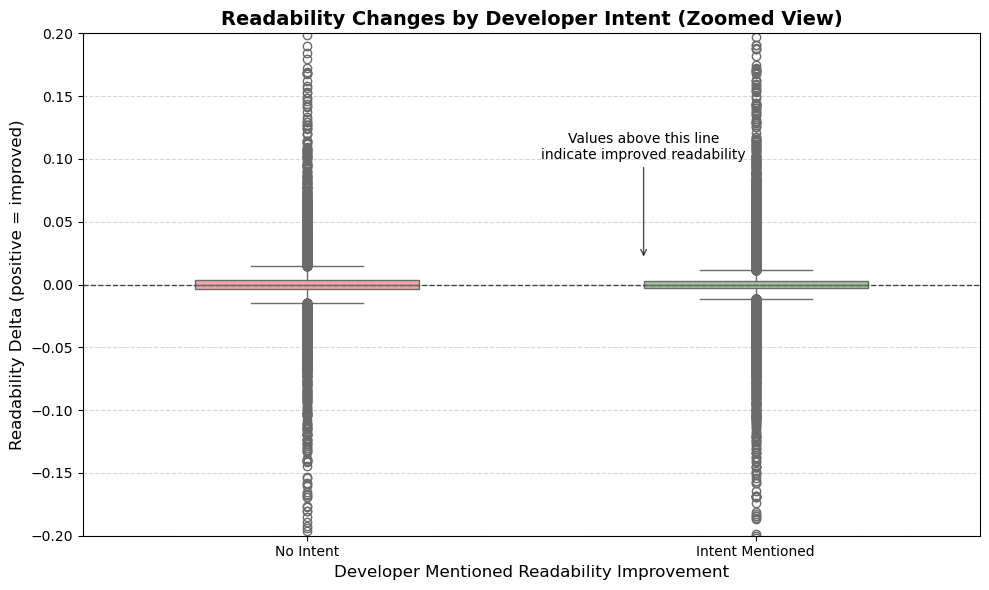

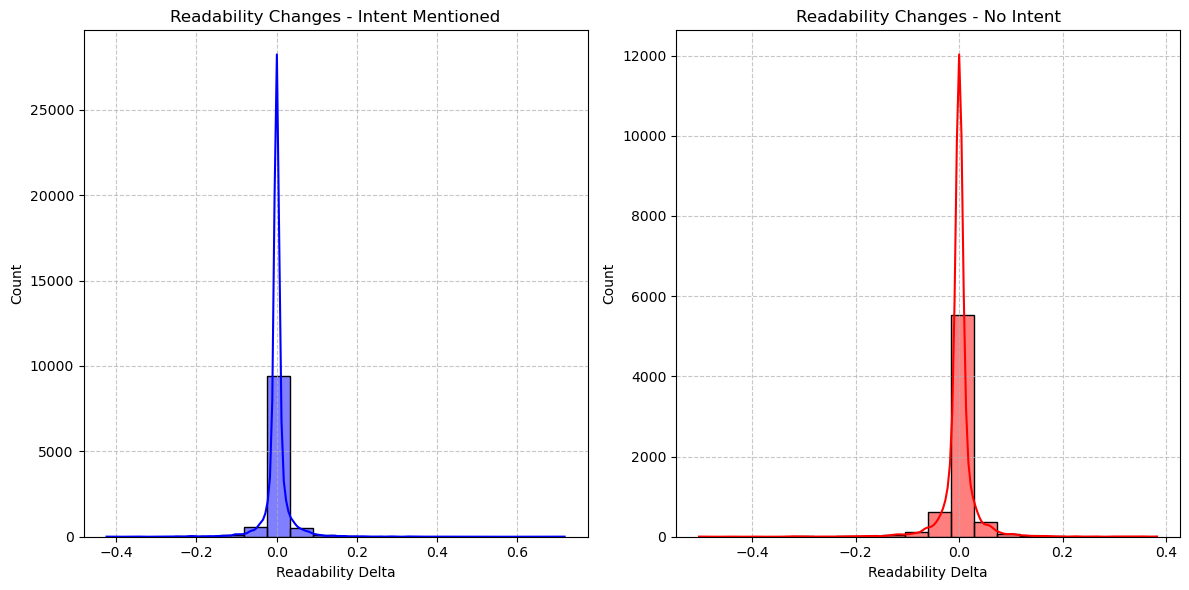

In [54]:
# Create a more zoomed-in boxplot for clearer visualization
plt.figure(figsize=(10, 6))

# Create the boxplot with all data
sns.boxplot(x='readability_intent', y='readability_delta', hue='readability_intent', 
            data=all_data, palette=['#FF9999', '#99CC99'], width=0.5, legend=False)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)

# Set y-axis limits to zoom in on the most relevant range
# Adjust these values based on your data distribution
plt.ylim(-0.2, 0.2)  # This focuses on the range from -0.2 to 0.2

# Add text annotations for the median values
medians = [all_data[all_data['readability_intent']==0]['readability_delta'],
           all_data[all_data['readability_intent']==1]['readability_delta']]

# Enhance the plot styling
plt.title('Readability Changes by Developer Intent (Zoomed View)', fontsize=14, fontweight='bold')
plt.xlabel('Developer Mentioned Readability Improvement', fontsize=12)
plt.ylabel('Readability Delta (positive = improved)', fontsize=12)
plt.xticks([0, 1], ['No Intent', 'Intent Mentioned'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add explanatory annotations
plt.annotate('Values above this line\nindicate improved readability', 
             xy=(0.75, 0.02), xytext=(0.75, 0.1), 
             ha='center', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))

plt.tight_layout()
plt.savefig('readability_intent_boxplot_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution plots for readability deltas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(all_data[all_data['readability_intent']]['readability_delta'], 
             kde=True, bins=20, color='blue')
plt.title('Readability Changes - Intent Mentioned', fontsize=12)
plt.xlabel('Readability Delta', fontsize=10)
plt.grid(linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.histplot(all_data[~all_data['readability_intent']]['readability_delta'], 
             kde=True, bins=20, color='red')
plt.title('Readability Changes - No Intent', fontsize=12)
plt.xlabel('Readability Delta', fontsize=10)
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('readability_distributions.png', dpi=300)
# plt.close()
plt.show()

In [58]:
# Statistical analysis
print("\n=== Statistical Analysis ===")

# Calculate basic statistics
print("\nDescriptive Statistics:")
print("\nReadability Changes when Intent is Mentioned:")
print(intent_readability.describe())
print("\nReadability Changes when No Intent is Mentioned:")
print(no_intent_readability.describe())

# Set significance level
alpha = 0.05

# Test for normality using D'Agostino-Pearson test
print("\nTesting for Normality:")
stat_intent, p_intent = stats.normaltest(intent_readability)
print(f"D'Agostino-Pearson Test for Intent Group: p-value = {p_intent:.4f}")
if p_intent < alpha:
    print("The data is NOT normally distributed")
else:
    print("The data appears to be normally distributed")

stat_no_intent, p_no_intent = stats.normaltest(no_intent_readability)
print(f"D'Agostino-Pearson Test for No Intent Group: p-value = {p_no_intent:.4f}")
if p_no_intent < alpha:
    print("The data is NOT normally distributed")
else:
    print("The data appears to be normally distributed")

# Perform Mann-Whitney U test (non-parametric) since data is likely not normal
print("\nStatistical Comparison:")
stat, p_value = stats.mannwhitneyu(intent_readability, no_intent_readability, alternative='two-sided')
print(f"Mann-Whitney U test: p-value = {p_value:.6f}")
if p_value < alpha:
    print("There is a statistically significant difference in readability changes between the groups")
else:
    print("There is NO statistically significant difference in readability changes between the groups")



=== Statistical Analysis ===

Descriptive Statistics:

Readability Changes when Intent is Mentioned:
count    10803.000000
mean         0.000973
std          0.034280
min         -0.424146
25%         -0.002778
50%          0.000000
75%          0.002918
max          0.717385
Name: readability_delta, dtype: float64

Readability Changes when No Intent is Mentioned:
count    6827.000000
mean       -0.000245
std         0.035103
min        -0.503054
25%        -0.003550
50%         0.000000
75%         0.003749
max         0.382641
Name: readability_delta, dtype: float64

Testing for Normality:
D'Agostino-Pearson Test for Intent Group: p-value = 0.0000
The data is NOT normally distributed
D'Agostino-Pearson Test for No Intent Group: p-value = 0.0000
The data is NOT normally distributed

Statistical Comparison:
Mann-Whitney U test: p-value = 0.579575
There is NO statistically significant difference in readability changes between the groups


In [60]:
# Statistical analysis
print("\n=== Statistical Analysis ===")

# Calculate basic statistics
print("\nDescriptive Statistics:")
print("\nReadability Changes when Intent is Mentioned:")
print(intent_readability.describe())
print("\nReadability Changes when No Intent is Mentioned:")
print(no_intent_readability.describe())



=== Statistical Analysis ===

Descriptive Statistics:

Readability Changes when Intent is Mentioned:
count    10803.000000
mean         0.000973
std          0.034280
min         -0.424146
25%         -0.002778
50%          0.000000
75%          0.002918
max          0.717385
Name: readability_delta, dtype: float64

Readability Changes when No Intent is Mentioned:
count    6827.000000
mean       -0.000245
std         0.035103
min        -0.503054
25%        -0.003550
50%         0.000000
75%         0.003749
max         0.382641
Name: readability_delta, dtype: float64


In [62]:
# Calculate effect size (Cohen's d)
mean_intent = intent_readability.mean()
mean_no_intent = no_intent_readability.mean()
pooled_std = np.sqrt((intent_readability.std()**2 + no_intent_readability.std()**2) / 2)
cohens_d = (mean_intent - mean_no_intent) / pooled_std if pooled_std != 0 else 0

print("\nEffect Size Analysis:")
print(f"Mean readability delta for intent group: {mean_intent:.4f}")
print(f"Mean readability delta for no intent group: {mean_no_intent:.4f}")
print(f"Difference in means: {mean_intent - mean_no_intent:.4f}")
print(f"Effect size (Cohen's d): {cohens_d:.4f}")

# Interpret effect size
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"

print(f"The effect size is {effect_interpretation}")

# Success rates by readability improvement intent
intent_count = all_data['readability_intent'].sum()
intent_improved = all_data[all_data['readability_intent']]['readability_improved'].sum()
intent_success_rate = (intent_improved / intent_count) * 100 if intent_count > 0 else 0

no_intent_count = len(all_data) - intent_count
no_intent_improved = all_data[~all_data['readability_intent']]['readability_improved'].sum()
no_intent_success_rate = (no_intent_improved / no_intent_count) * 100 if no_intent_count > 0 else 0



Effect Size Analysis:
Mean readability delta for intent group: 0.0010
Mean readability delta for no intent group: -0.0002
Difference in means: 0.0012
Effect size (Cohen's d): 0.0351
The effect size is negligible


In [64]:
# Success rates by category
category_success = {category: {'attempted': 0, 'succeeded': 0} for category in readability_keywords.keys()}

for _, row in all_data.iterrows():
    commit_msg = row['commit_msg']
    if not isinstance(commit_msg, str):
        continue
    
    commit_msg = commit_msg.lower()
    readability_improved = row['readability_improved']
    
    for category, keywords in readability_keywords.items():
        if any(keyword in commit_msg for keyword in keywords):
            category_success[category]['attempted'] += 1
            if readability_improved:
                category_success[category]['succeeded'] += 1

# Calculate success rates by category
success_rates = []
for category, counts in category_success.items():
    if counts['attempted'] > 0:
        success_rate = (counts['succeeded'] / counts['attempted']) * 100
        success_rates.append({
            'Category': category,
            'Attempted': counts['attempted'],
            'Succeeded': counts['succeeded'],
            'Success Rate (%)': success_rate
        })

success_df = pd.DataFrame(success_rates).sort_values('Success Rate (%)', ascending=False)


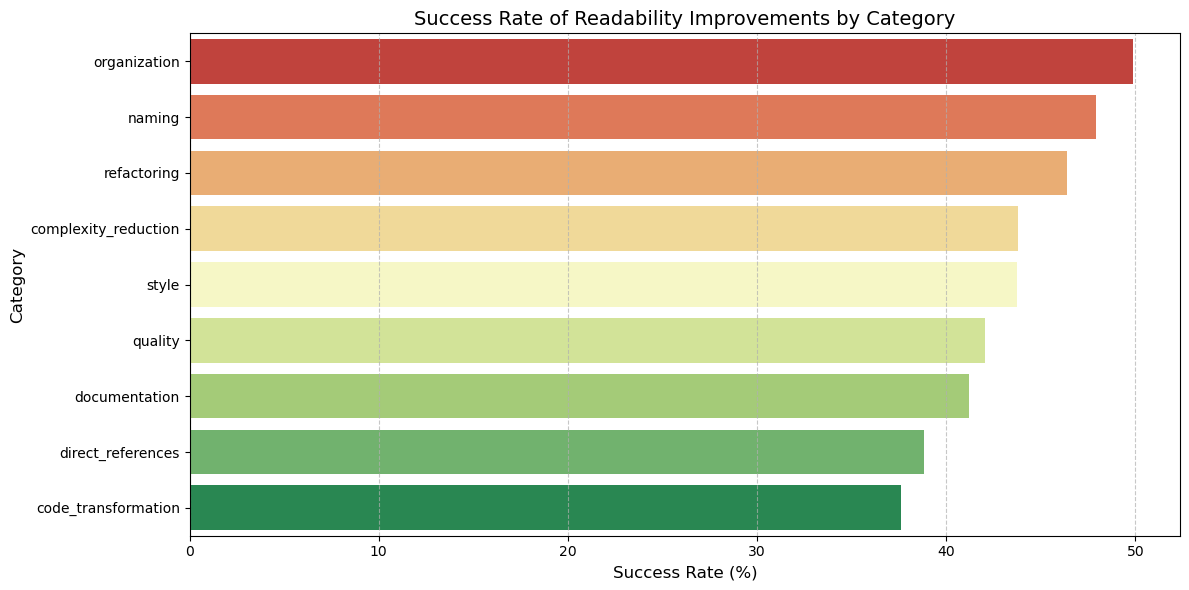

In [66]:
# Plot success rates by category
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Success Rate (%)', 
    y='Category', 
    hue='Category',
    data=success_df, 
    palette='RdYlGn',
    legend=False
)
plt.title('Success Rate of Readability Improvements by Category', fontsize=14)
plt.xlabel('Success Rate (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('readability_success_rates.png', dpi=300, bbox_inches='tight')
# plt.close()
plt.show()